DRW tau=36714.3944535726
DRW sigma=[0.31145523]
sinusoidal signal amplitude=0.341641233979946
sinusoidal signal period=2447.773173986793
Sin Phase=5.553126483859719
total num observations=259


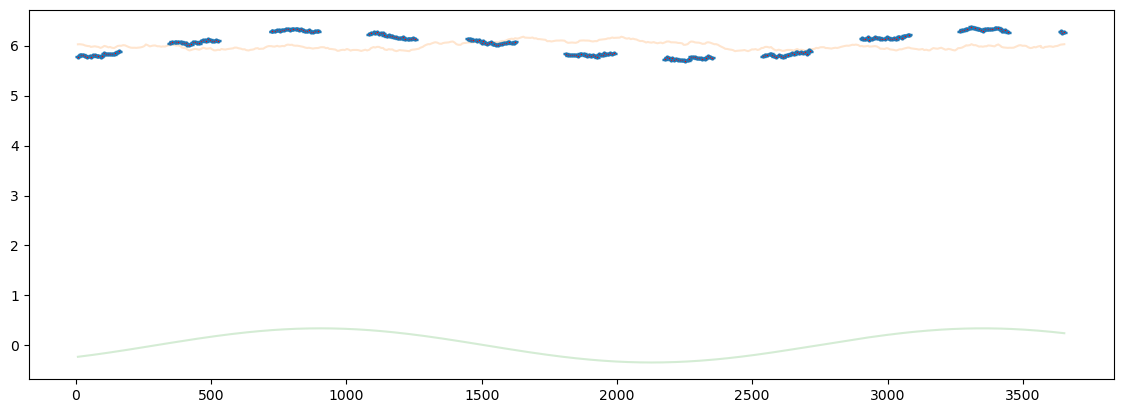

In [21]:
# Generate lightcurve and plot as a graph
import matplotlib.pyplot as plt
import math
import LightCurveSimulation as LC

is_binary = True
lcsim = LC.LightCurveSimulation()
(t, mag, magerr, t_comp, comp_drw, comp_sin) = lcsim.generate_light_curve(LC.LSST, is_binary) #  generateFixedSample / generateRandomSample(LSST) 
plt.figure().set_figwidth(14)
plt.errorbar(t, mag, yerr=magerr, fmt='o', ms=2, mfc='red', lw=0.5,capsize=2, mouseover=True)
plt.plot(t_comp, comp_drw, alpha=0.2)
if is_binary:
    plt.plot(t_comp, comp_sin, alpha=0.2)

plt.show()

In [29]:
# Generate light curve and export data as CSV
import numpy as np

is_binary = True
(t, mag, magerr) = lcsim.generate_light_curve(LC.LSST, is_binary)
np.savetxt("output/light_curve_" + str(is_binary) + ".csv", 
           np.vstack((mag, magerr, t)).T, 
           header='Mag, Magerr, MJD', delimiter=",", fmt='%.4f')


DRW tau=32344.58716033324
DRW sigma=[0.57584965]
sinusoidal signal amplitude=0.13721966293845958
sinusoidal signal period=2935.754799055408
Sin Phase=4.562411823718535
total num observations=260


ValueError: too many values to unpack (expected 3)